In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
#pip install git+https://github.com/KindXiaoming/pykan.git
import sys


In [2]:
test_data_X = pd.read_csv(r"C:\Users\ADMIN\Desktop\Thesis Space Desktop\Data After Preprocess\processed_test_data_X_data.csv")
train_data_X = pd.read_csv(r"C:\Users\ADMIN\Desktop\Thesis Space Desktop\Data After Preprocess\processed_train_data_X_data.csv")
test_labels_encoded = pd.read_csv(r"C:\Users\ADMIN\Desktop\Thesis Space Desktop\Data After Preprocess\processed_test_data_y_data.csv")
train_labels_encoded = pd.read_csv(r"C:\Users\ADMIN\Desktop\Thesis Space Desktop\Data After Preprocess\processed_train_data_y_data.csv")

# Oversampling

In [3]:
from imblearn.under_sampling import EditedNearestNeighbours

In [4]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import EditedNearestNeighbours
#ENN reduces the majority class by keeping only well separated instances
enn = EditedNearestNeighbours(sampling_strategy = "all", n_neighbors = 3)
#train_data_X, train_data_y = enn.fit_resample(train_data_X, train_labels_encoded)

In [5]:
from imblearn.combine import SMOTEENN

# Combine SMOTE (oversampling) and ENN (cleaning majority class)
smote_enn = SMOTEENN(sampling_strategy="auto", enn = enn, random_state=42)

# Apply SMOTEENN
train_data_X, train_data_y = smote_enn.fit_resample(train_data_X, train_labels_encoded)

# Check the class distribution after resampling
from collections import Counter
print(f"Class distribution after resampling: {Counter(train_data_y)}")

Class distribution after resampling: Counter({'0': 1})


In [6]:
train_data_y.value_counts()

0
9    48419
8    48024
5    47993
6    40151
7    38681
4    37744
3    20377
1    16207
0    15069
2     7693
Name: count, dtype: int64

# Feature Selection

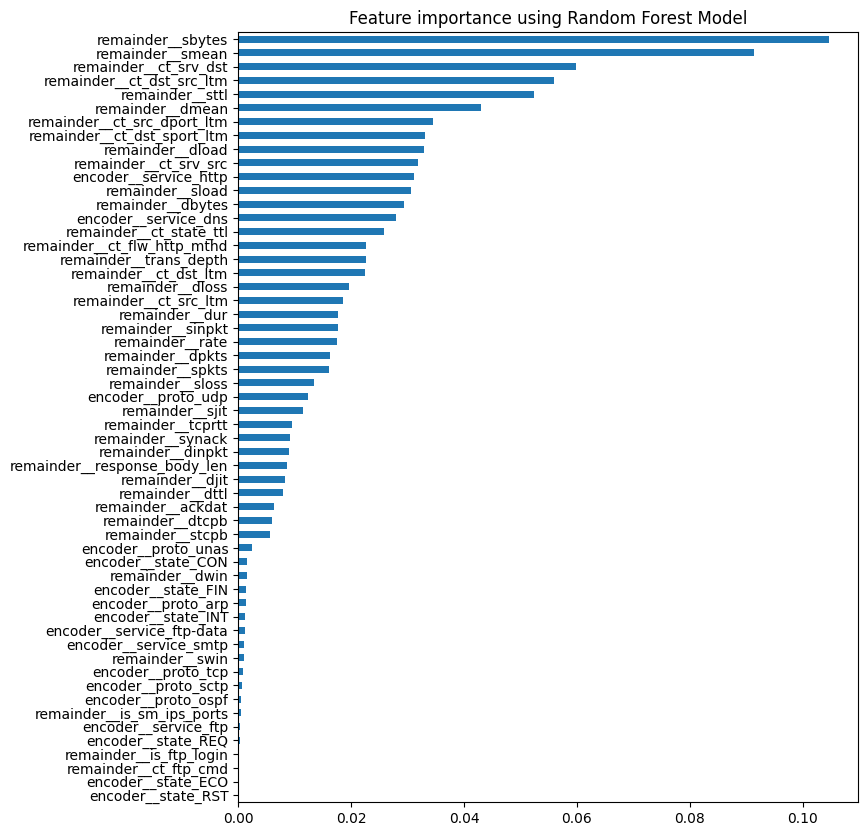

In [7]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(random_state=15)
numeric_cols = train_data_X.select_dtypes(include = "number")
rf_classifier.fit(numeric_cols, train_data_y.values.ravel())

feature_importances = pd.Series(rf_classifier.feature_importances_, index=numeric_cols.columns)

def plot_importance(coef, name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind="barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

plot_importance(feature_importances, 'Random Forest')

In [8]:
feature_importances

encoder__proto_arp              1.423938e-03
encoder__proto_ospf             5.737111e-04
encoder__proto_sctp             7.675048e-04
encoder__proto_tcp              9.218105e-04
encoder__proto_udp              1.239060e-02
encoder__proto_unas             2.539901e-03
encoder__service_dns            2.802601e-02
encoder__service_ftp            2.984832e-04
encoder__service_ftp-data       1.249085e-03
encoder__service_http           3.107060e-02
encoder__service_smtp           1.016171e-03
encoder__state_CON              1.583040e-03
encoder__state_ECO              1.229655e-05
encoder__state_FIN              1.443736e-03
encoder__state_INT              1.293721e-03
encoder__state_REQ              2.780036e-04
encoder__state_RST              7.956273e-07
remainder__dur                  1.773911e-02
remainder__spkts                1.616208e-02
remainder__dpkts                1.620512e-02
remainder__sbytes               1.045401e-01
remainder__dbytes               2.934138e-02
remainder_

In [9]:
top_40_features = [
    "sttl",
    "PC1",
    "dttl",
    "ct_dst_src_ltm",
    "ct_dst_ltm",
    "ct_dst_sport_ltm",
    "ct_state_ttl",
    "ct_src_dport_ltm",
    "ct_src_ltm",
    "ct_srv_dst",
    "ct_srv_src",
    "ackdat",
    "tcprtt",
    "sbytes",
    "smean",
    "dload",
    "rate",
    "dmean",
    "dur",
    "PC3",
    "PC10",
    "dbytes",
    "synack",
    "PC2",
    "ct_flw_http_mthd",
    "trans_depth",
    "PC4",
    "sload",
    "PC5",
    "sinpkt",
    "PC8",
    "spkts",
    "dpkts",
    "PC9",
    "sloss",
    "sjit",
    "PC7",
    "dloss",
    "dwin",
    "swin"
]

In [10]:
from sklearn.feature_selection import f_classif #computes ANOVA 
from sklearn.feature_selection import SelectKBest  #Orders f statistics and selects the Kbest ones

def anova_test():

    
    X_vars = train_data_X[train_data_X.select_dtypes(include='number').columns]
    
    y_var = train_data_y
    
    anova = SelectKBest(f_classif, k=40) #we choose to keep the 10 best ones, try different numbers
    
    
    X_anova = anova.fit_transform(X_vars, y_var)
    
    anova_results = pd.DataFrame({'Feature': X_vars.columns, 
                                  'F-value': anova.scores_,
                                  'p-value': anova.pvalues_})
    
    anova_results.sort_values(by='F-value', ascending=False, inplace=True)

    
    selected_features = pd.Series(anova.get_support(), index = X_vars.columns)
    features_to_use = [feature for feature, keep in selected_features.items() if keep]

    features_to_use_str = '", "'.join(features_to_use)
    
    return selected_features, anova_results, features_to_use_str,features_to_use

In [11]:
selected_features, anova_results, features_to_use_str,features_to_use = anova_test()

C:\Users\ADMIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [12]:
features = features_to_use

# Modelling

## Modelling EfficentKan

In [13]:
#train_X_tensor = torch.tensor(train_data_X[features].values, dtype=torch.float32).squeeze()
#test_X_tensor = torch.tensor(test_data_X[features].values, dtype=torch.float32).squeeze() #changed to have all features

train_X_tensor = torch.tensor(train_data_X[features_to_use].values, dtype=torch.float32).squeeze()
test_X_tensor = torch.tensor(test_data_X[features_to_use].values, dtype=torch.float32).squeeze()

train_Y_tensor = torch.tensor(train_data_y.values, dtype=torch.long).squeeze()
test_Y_tensor = torch.tensor(test_labels_encoded.values, dtype=torch.long).squeeze()
#a dictionary with the 4 datasets

In [14]:
from torch import nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [15]:

# Create TensorDatasets
train_dataset = TensorDataset(train_X_tensor, train_Y_tensor)
test_dataset = TensorDataset(test_X_tensor, test_Y_tensor)


In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Modelling with efficient Kan

In [17]:
from efficient_kan import KAN

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from tqdm import tqdm

# Define model
model = KAN([40, 64, 10])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# Define learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

# Define loss
criterion = nn.CrossEntropyLoss()

In [19]:
model.grid_size, model.spline_order

(5, 3)

In [20]:
from sklearn.model_selection import KFold

In [24]:
model = KAN([40, 15,6, 3,10],grid_size = 6, scale_noise=0.4, scale_base=0.2, scale_spline=0.2)

In [28]:
import torch
import torch.nn as nn

class NeuralNetwork(nn.Module):
    def __init__(self, input_shape: int, hidden_units1: int, hidden_units2: int, hidden_units3: int, hidden_units4: int, output_shape: int):
        super().__init__()
        self.flatten = nn.Flatten()

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features=input_shape, out_features=hidden_units1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=hidden_units1, out_features=hidden_units1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=hidden_units1, out_features=hidden_units2),
        )

        self.linear_relu_stack2 = nn.Sequential(
            nn.Linear(in_features=hidden_units2, out_features=hidden_units2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=hidden_units2, out_features=hidden_units2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=hidden_units2, out_features=hidden_units3),
        )

        # **New Block Added Here**
        self.linear_relu_stack3 = nn.Sequential(
            nn.Linear(in_features=hidden_units3, out_features=hidden_units3),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=hidden_units3, out_features=hidden_units3),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=hidden_units3, out_features=hidden_units4),
        )

        self.linear_relu_stack4 = nn.Sequential(
            nn.Linear(in_features=hidden_units4, out_features=hidden_units4),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=hidden_units4, out_features=hidden_units4),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=hidden_units4, out_features=output_shape),
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        x = self.linear_relu_stack2(x)
        x = self.linear_relu_stack3(x)  # Pass through new block
        logits = self.linear_relu_stack4(x)  # Final output layer

        return logits



In [29]:
model_test = NeuralNetwork(40,128,64,32,10,10)

In [25]:
from sklearn.metrics import f1_score

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    correct = 0  # For accuracy tracking
    total = 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
        # Calculate accuracy
        _, predicted = torch.max(pred, 1)
        correct += (predicted == y).sum().item()
        total += y.size(0)

    accuracy = correct / total * 100
    print(f"Train Accuracy: {accuracy:.4f}%")

def test_loop(dataloader, model, loss_fn):
    model.eval()  # Set the model to evaluation mode
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
            # Collect all predictions and true labels for F1-score calculation
            all_preds.extend(pred.argmax(1).cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    test_loss /= num_batches
    correct /= size
    f1 = f1_score(all_labels, all_preds, average='weighted') * 100  # Weighted F1-score to handle class imbalance

    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}, F1-score: {f1:.2f}% \n")


In [30]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.565036  [    0/320358]
loss: 0.508508  [ 3200/320358]
loss: 0.608961  [ 6400/320358]
loss: 0.343135  [ 9600/320358]
loss: 0.347622  [12800/320358]
loss: 0.301987  [16000/320358]
loss: 0.293260  [19200/320358]
loss: 0.221322  [22400/320358]


KeyboardInterrupt: 

In [31]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model_test, loss_fn, optimizer)
    test_loop(test_dataloader, model_test, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.327130  [    0/320358]
loss: 2.351715  [ 3200/320358]
loss: 2.339998  [ 6400/320358]
loss: 2.320524  [ 9600/320358]
loss: 2.306493  [12800/320358]
loss: 2.279196  [16000/320358]
loss: 2.310038  [19200/320358]
loss: 2.344257  [22400/320358]
loss: 2.249393  [25600/320358]
loss: 2.354445  [28800/320358]
loss: 2.262890  [32000/320358]
loss: 2.355504  [35200/320358]
loss: 2.257092  [38400/320358]
loss: 2.311550  [41600/320358]
loss: 2.284803  [44800/320358]
loss: 2.329403  [48000/320358]
loss: 2.311256  [51200/320358]
loss: 2.311094  [54400/320358]
loss: 2.316396  [57600/320358]
loss: 2.319775  [60800/320358]
loss: 2.275367  [64000/320358]
loss: 2.270278  [67200/320358]
loss: 2.245181  [70400/320358]
loss: 2.352472  [73600/320358]
loss: 2.333477  [76800/320358]
loss: 2.314871  [80000/320358]
loss: 2.210132  [83200/320358]
loss: 2.261020  [86400/320358]
loss: 2.282528  [89600/320358]
loss: 2.340223  [92800/320358]
loss: 2.263973  [96000/320358]

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import f1_score

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    correct = 0  # For accuracy tracking
    total = 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
        # Calculate accuracy
        _, predicted = torch.max(pred, 1)
        correct += (predicted == y).sum().item()
        total += y.size(0)
    

    accuracy = correct / total * 100
    print(f"Train Accuracy: {accuracy:.4f}%")

def test_loop(dataloader, model, loss_fn):
    model.eval()  # Set the model to evaluation mode
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
            # Collect all predictions and true labels for F1-score calculation
            all_preds.extend(pred.argmax(1).cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    test_loss /= num_batches
    correct /= size
    f1 = f1_score(all_labels, all_preds, average='weighted') * 100  # Weighted F1-score to handle class imbalance

    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}, F1-score: {f1:.2f}% \n")


In [ ]:
model = KAN([40, 20,6, 3,10],grid_size = 3, scale_noise=0.2)

In [ ]:
from torch.optim import lr_scheduler

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

In [ ]:
model = KAN([40, 15,6, 3,10],grid_size = 4, scale_noise=0.2)

In [ ]:
from torch.optim import lr_scheduler

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

In [ ]:
model = KAN([40, 10,6, 3,10],grid_size = 4, scale_noise=0.2)

In [ ]:
from torch.optim import lr_scheduler

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

In [ ]:
# Smoothing function using a moving average
def smooth_loss(losses, window_size=100):
    """
    Smooth the loss values using a moving average.
    :param losses: List of loss values.
    :param window_size: Size of the moving window.
    :return: Smoothed loss values.
    """
    smoothed_losses = np.convolve(losses, np.ones(window_size) / window_size, mode='valid')
    return smoothed_losses

# Plot the training loss over time
plt.figure(figsize=(10, 6))

# Smooth and plot training loss for each fold
for fold, losses in enumerate(all_losses):
    smoothed_loss = smooth_loss(losses, window_size=100)  # Adjust window_size as needed
    plt.plot(smoothed_loss, label=f'Fold {fold + 1}')

# Calculate and plot the average smoothed loss across folds
avg_loss = np.mean(all_losses, axis=0)
smoothed_avg_loss = smooth_loss(avg_loss, window_size=100)
plt.plot(smoothed_avg_loss, label='Average Loss', linewidth=2, color='black')

plt.xlabel('Mini-Batch Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Over Mini-Batches (Smoothed)')
plt.legend()
plt.show()

In [ ]:
print(f"Total Mini-Batches per Epoch: {len(trainloader)}")

# Confusion Matrix

In [ ]:
import pickle
import pandas as pd

# Load the LabelEncoder object from the file
with open(r"C:\Users\ADMIN\Desktop\Thesis Space Desktop\Data After Preprocess\label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)


# Now you can use the label_encoder object in the second notebook
original_class_labels = label_encoder.classes_

In [ ]:
original_labels_test = label_encoder.inverse_transform(test_labels_encoded.values.flatten())

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ensure the model is in evaluation mode
model.eval()

with torch.no_grad():
    y_pred = model(test_X_tensor)  # Forward pass
    y_pred = torch.argmax(y_pred, dim=1)  # Get class predictions

# Convert tensors to NumPy arrays for sklearn
y_pred = y_pred.cpu().numpy()
y_true = test_Y_tensor.cpu().numpy()

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get class labels from the LabelEncoder
class_labels = label_encoder.classes_

fig, ax = plt.subplots(figsize=(12, 8))  #Creates both a figure and an ax

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', values_format='d', ax=ax)

# Rotate axis labels for better visibility
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Show the plot
plt.show()

In [ ]:
import torch.nn.functional as F

with torch.no_grad():
    y_score = F.softmax(model(test_X_tensor), dim=1)

In [ ]:
np.average(y_score.numpy())

In [ ]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(train_data_y)
y_onehot_test = label_binarizer.transform(test_labels_encoded)
y_onehot_test.shape  # (n_samples, n_classes)

In [ ]:
from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR",
    color="darkorange",
    plot_chance_level=True)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)